Cheatsheet

```df.loc[row, col]```

Sum up the first three cells of each column
sum_first_three = df.iloc[:3].sum()


## Importing, Preparation

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read kepler CSV
kepler_data = pd.read_csv("CSV-experimental/Load2 Pod_Process Power Consumption (W) in Namespace_ All-data-as-joinbyfield-2023-12-12 22_23_44.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels
#read zeebe CSV
zeebe_data = pd.read_csv("CSV-experimental/Load2 Job completion per second-data-2023-12-12 22_27_16.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read zeebe CSV
cpu_data = pd.read_csv("CSV-experimental/Load2 CPU Usage-data-as-joinbyfield-2023-12-12 22_31_28.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

cpu_test_sum = cpu_data.sum(axis=1)

In [41]:
# read namespaces from columns. 
# This relies on grafana CSV-outputs using '/' as a divider: "pod / namespace / domain"
def extract_namespaces(df):
    namespaces = []
    for col in df.columns:
        split_col = col.split('/')
        if len(split_col) > 1:
            namespace = split_col[1].strip()
            if namespace not in namespaces:
                namespaces.append(namespace)
    return namespaces;

namespaces = extract_namespaces(kepler_data)

namespaces

['camunda8',
 'kube-system',
 'load-controller',
 'measuring-endpoints',
 'monitoring',
 'system',
 'worker']

['camunda-platform-connectors-7fd698449b-vvm76', 'camunda-platform-elasticsearch-master-0', 'camunda-platform-elasticsearch-master-1', 'camunda-platform-operate-5bc7c489c4-8xh6n', 'camunda-platform-tasklist-9968d5594-82sgg', 'camunda-platform-zeebe-0', 'camunda-platform-zeebe-gateway-5ff76496c4-vf4q5', 'console-worker-console-worker-chart-camunda-8-go-console-whvxc2', 'camunda-platform-connectors-7fd698449b-vvm76', 'camunda-platform-elasticsearch-master-0', 'camunda-platform-elasticsearch-master-1', 'camunda-platform-operate-5bc7c489c4-8xh6n', 'camunda-platform-tasklist-9968d5594-82sgg', 'camunda-platform-zeebe-0', 'camunda-platform-zeebe-gateway-5ff76496c4-vf4q5', 'console-worker-console-worker-chart-camunda-8-go-console-whvxc2', 'camunda-platform-connectors-7fd698449b-vvm76', 'camunda-platform-elasticsearch-master-0', 'camunda-platform-elasticsearch-master-1', 'camunda-platform-operate-5bc7c489c4-8xh6n', 'camunda-platform-tasklist-9968d5594-82sgg', 'camunda-platform-zeebe-0', 'camund

<Axes: title={'center': "received 'job complete' commands in zeebe"}, xlabel='Time'>

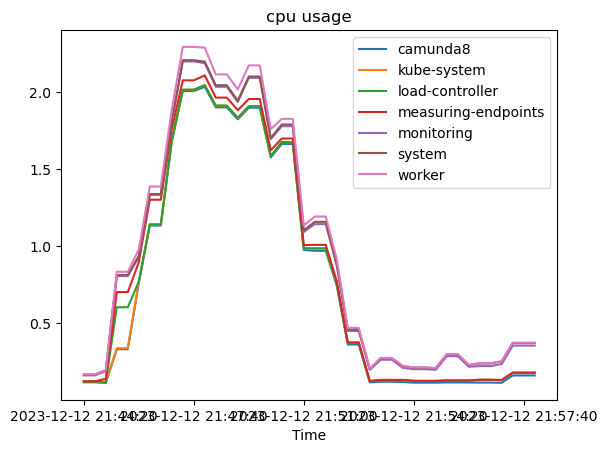

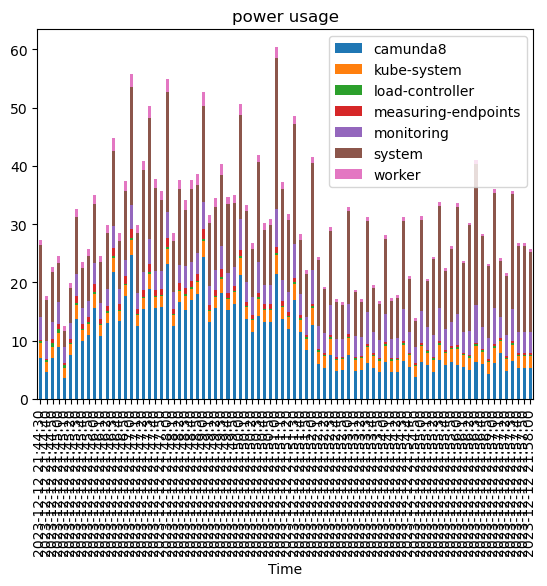

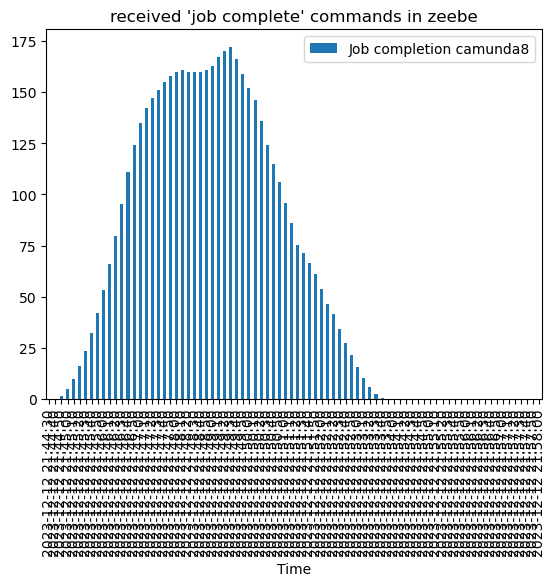

In [42]:
# group by namespace, use kepler data to group cpu_data (columns don't contain namespaces)

namespaces = extract_namespaces(kepler_data)

namespaces_sum_kepler = pd.DataFrame()
namespaces_sum_cpu = pd.DataFrame()


for namespace in namespaces:

    # group kepler data
    namespace_cols = [col for col in kepler_data.columns if namespace in col]
    namespaces_sum_kepler[namespace] = kepler_data[namespace_cols].sum(axis=1)  

    # group cpu data
    pod_names = []
    for col in kepler_data:
        if namespace in col:
            pod_name = col.split('/')[0].strip()
            pod_names.append(pod_name)
    
    print(pod_names)
    namespaces_sum_cpu[namespace] = cpu_data[[col for col in cpu_data.columns if col in pod_names]].sum(axis=1) 

namespaces_sum_cpu.plot(stacked=True, title='cpu usage')
namespaces_sum_kepler.plot(kind="bar", stacked=True, title='power usage')
zeebe_data.plot(kind="bar",title='received \'job complete\' commands in zeebe')

<Axes: xlabel='Time'>

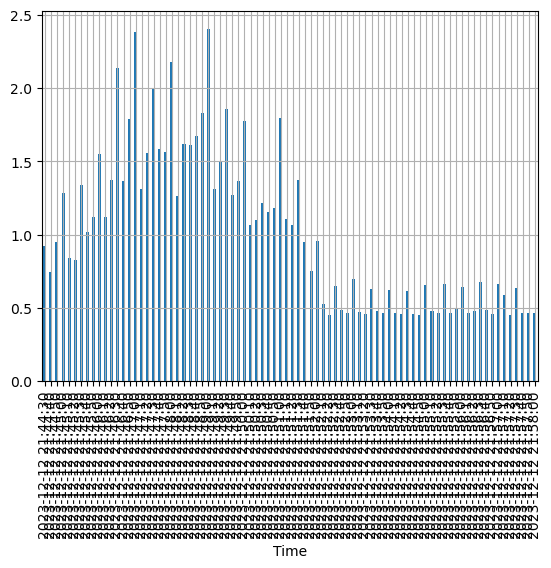

In [43]:
namespaces_sum_kepler['worker'].plot(kind="bar", grid=True)

In [44]:
# remove irrelevant columns: 

columns_to_keep = rawdata.columns[~rawdata.columns.str.contains('OTHER|measuring-endpoints|monitoring|console-worker|tasklist|operate|bpmndeployment|processstart|elasticsearch|connectors|load-controller')]
data = rawdata.loc[:, columns_to_keep]

data

NameError: name 'rawdata' is not defined

In [ ]:
# extract measurements. use list of start_times and measurements_per_cycle (amount of datapoints)
def split_data_into_cycles(df, start_times, measurements_per_cycle):
    cycles = []
    # Select all rows belonging to a cycle
    for item in start_times:
        temp = pd.DataFrame()

        index = df.index.get_loc(item)

        temp = df.iloc[index:index + measurements_per_cycle,:]
        temp = temp.dropna(how="all", axis=1)

        cycles.append(temp)
    
    return cycles;

# every Cycle with 30 measurements is 1 entry in list
STEPS_PER_CYCLE = 30 # 5 Min * 6 Scrapes/Min

cycles = split_data_into_cycles(data, start_times,STEPS_PER_CYCLE)

In [ ]:
# read namespaces from columns. 
# This relies on grafana CSV-outputs using '/' as a divider: "pod / namespace / domain"
def extract_namespaces(df):
    namespaces = []
    for col in df.columns:
        split_col = col.split('/')
        if len(split_col) > 1:
            namespace = split_col[1].strip()
            if namespace not in namespaces:
                namespaces.append(namespace)
    return namespaces;


In [ ]:
# for each cycle, group all pods from namespace
def group_namespaces_per_cycle(cycles):
    grouped_cycles = []
    namespaces = extract_namespaces(data)

    for item in cycles:
        temp = pd.DataFrame()

        for namespace in namespaces:
            namespace_cols = [col for col in item.columns if namespace in col]
            temp[namespace] = item[namespace_cols].sum(axis=1)  

        grouped_cycles.append(temp)
    
    return grouped_cycles;


cycles_by_namespace = group_namespaces_per_cycle(cycles)

In [ ]:
# create relative timestamps

def create_relative_timestamps(min, max, interval):
    elapsed_times = []
    for i in range(min,int(max/interval)):
        s = i * interval % 60
        m = int(i / (60 / interval))
        elapsed_times.append("{:02d}:{:02d}".format(m,s))

    return elapsed_times;

elapsed_times = create_relative_timestamps(0, 300, 10)

# elapsed_times


In [ ]:
# create single dataframe for namespace for better readability
def isolate_namespace_per_cycle(namespace, cycles_list):
    df = pd.DataFrame(index=elapsed_times)
    
    for item in cycles_list:
        temp = item[namespace]
        temp.index = elapsed_times
        
        df[item.index[0]] = temp
    
    return df;

all_camunda_series = isolate_namespace_per_cycle("camunda8", cycles_by_namespace)
all_system_series = isolate_namespace_per_cycle("system", cycles_by_namespace)
all_worker_series = isolate_namespace_per_cycle("worker", cycles_by_namespace)
all_kube_system_series = isolate_namespace_per_cycle("kube-system", cycles_by_namespace)

<Axes: title={'center': 'System'}, xlabel='Time', ylabel='Consumed Power [W] - raw'>

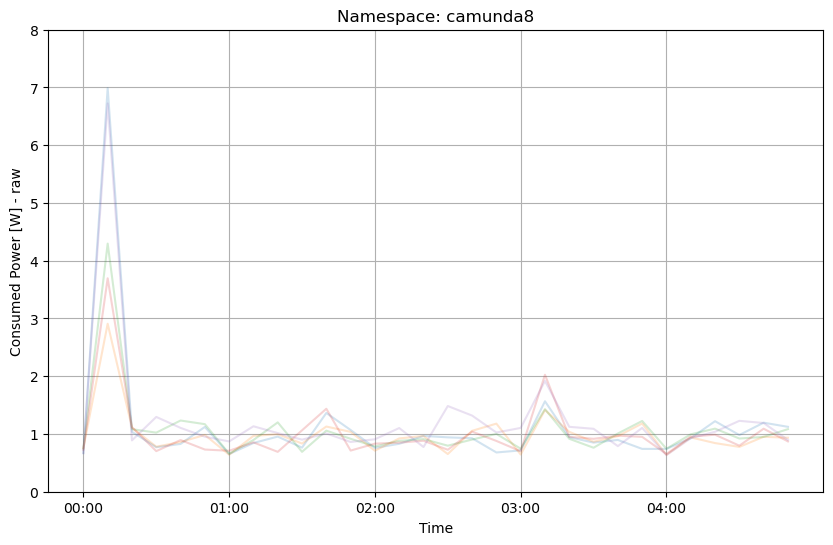

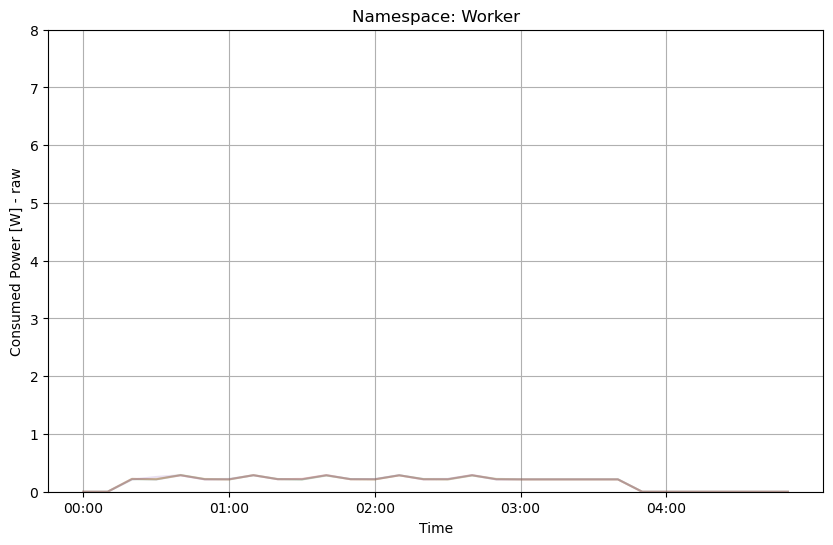

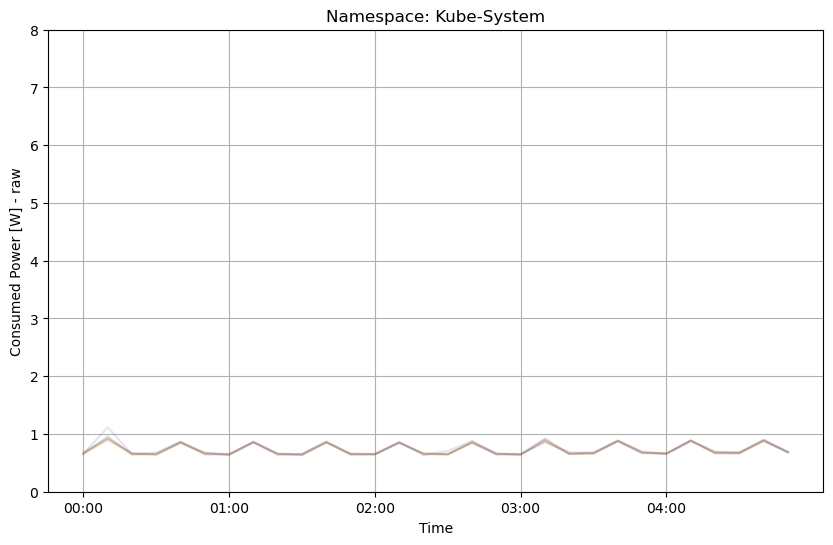

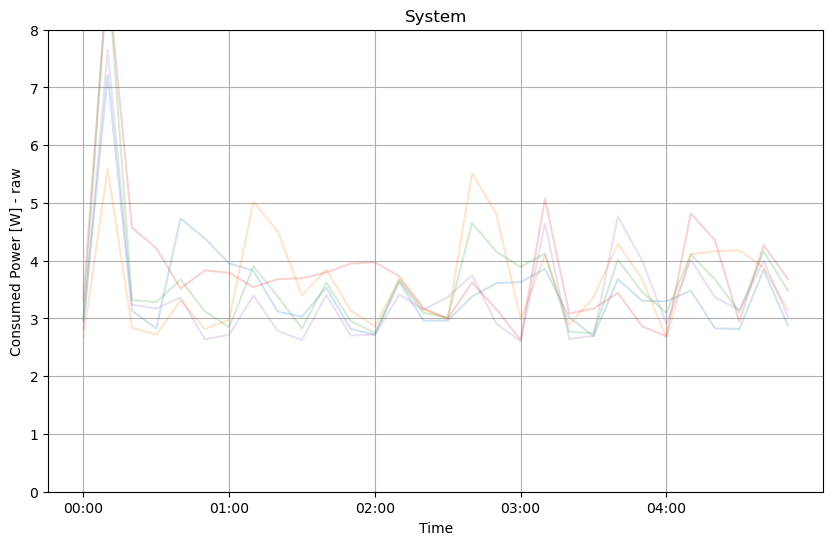

In [ ]:
# plot results
ylim=[0,8] 
figsize = [10,6]
alpha=0.2
x_ticks = [0,6,12,18,24]
grid=True

all_camunda_series.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: camunda8", xlabel='Time', ylabel='Consumed Power [W] - raw')
all_worker_series.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: Worker", xlabel='Time', ylabel='Consumed Power [W] - raw')
all_kube_system_series.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: Kube-System", xlabel='Time', ylabel='Consumed Power [W] - raw')
all_system_series.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "System", xlabel='Time', ylabel='Consumed Power [W] - raw')

## Identifying Outliers

<Axes: title={'center': 'Each Cycle in Minute 5'}>

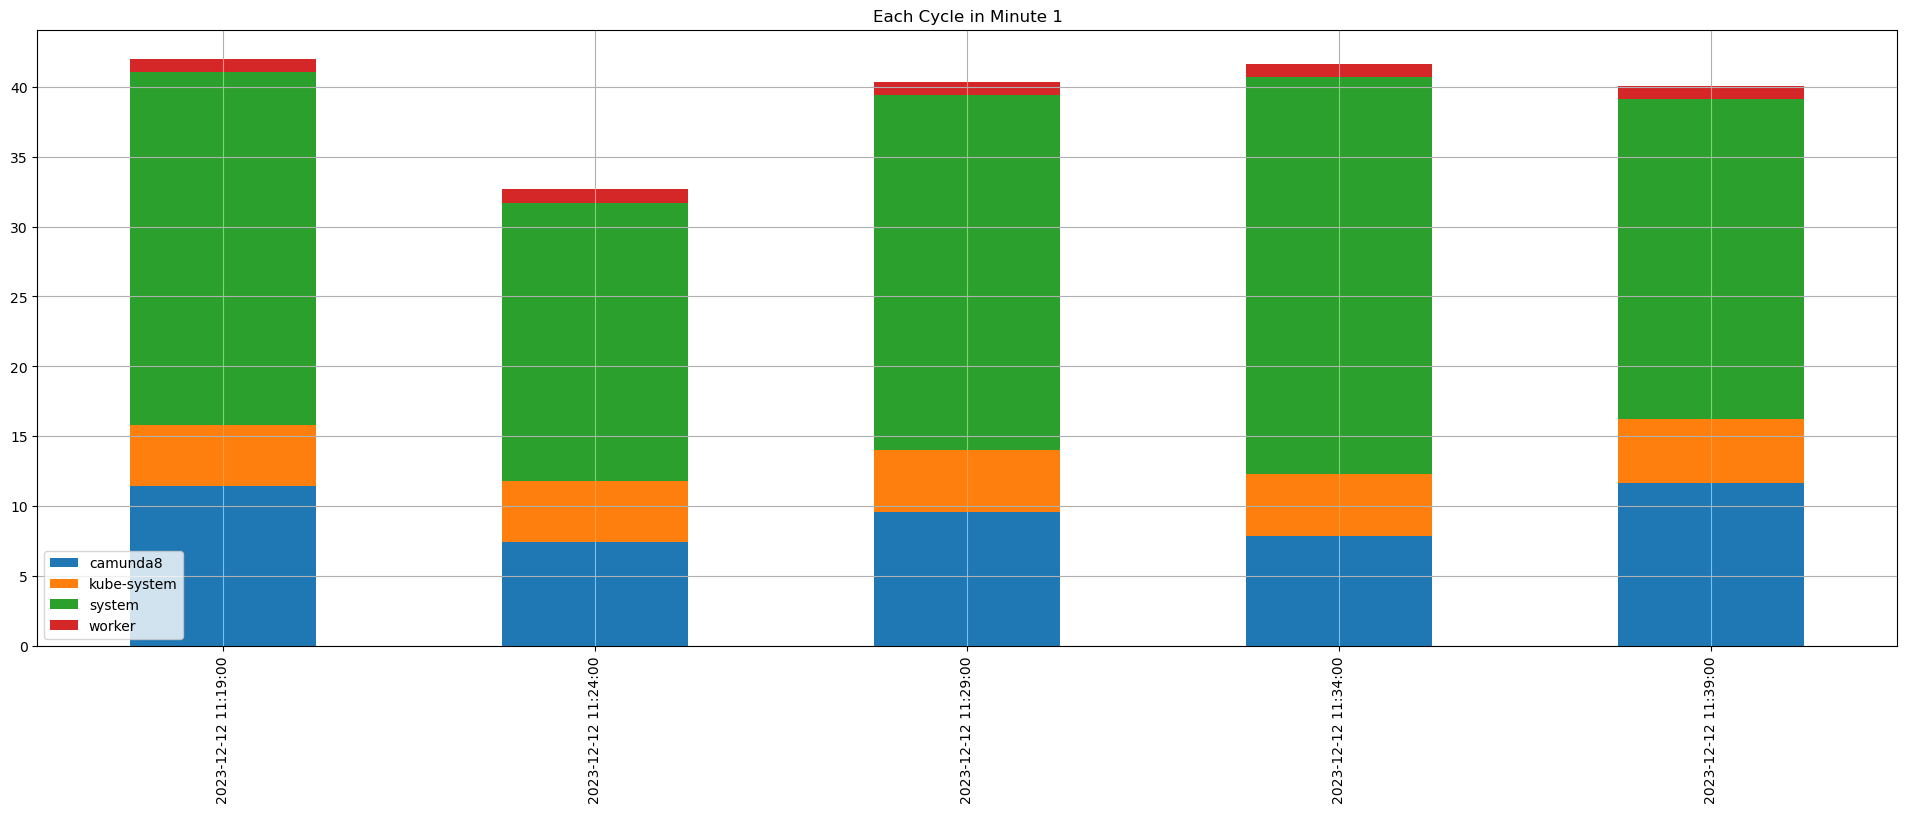

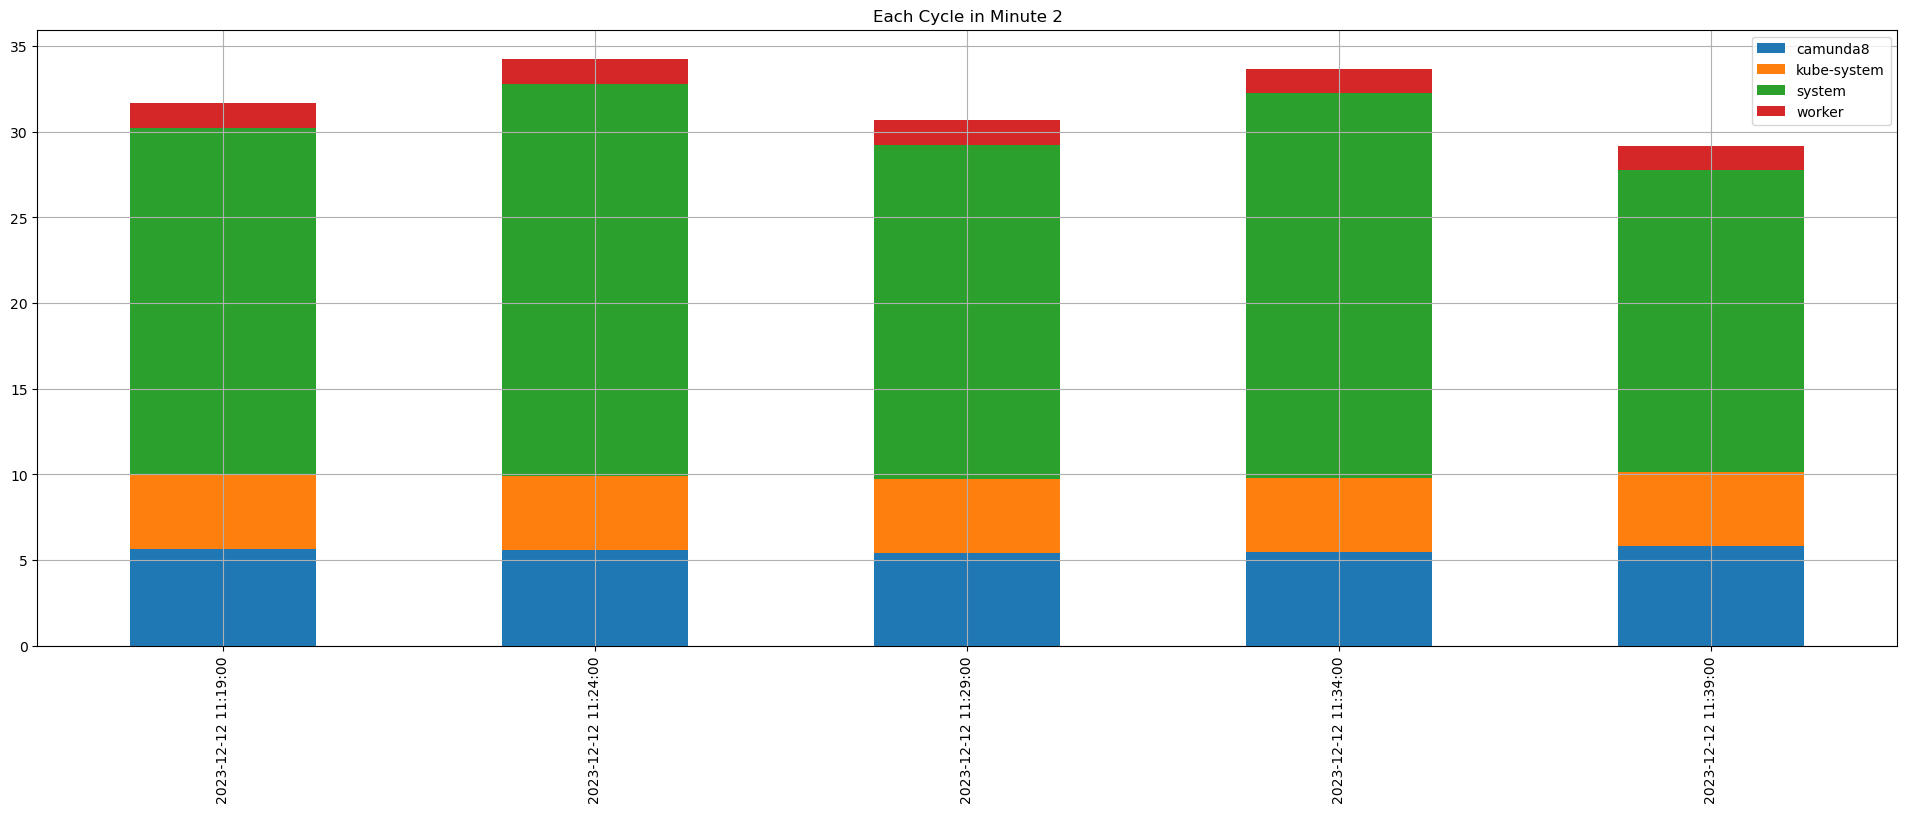

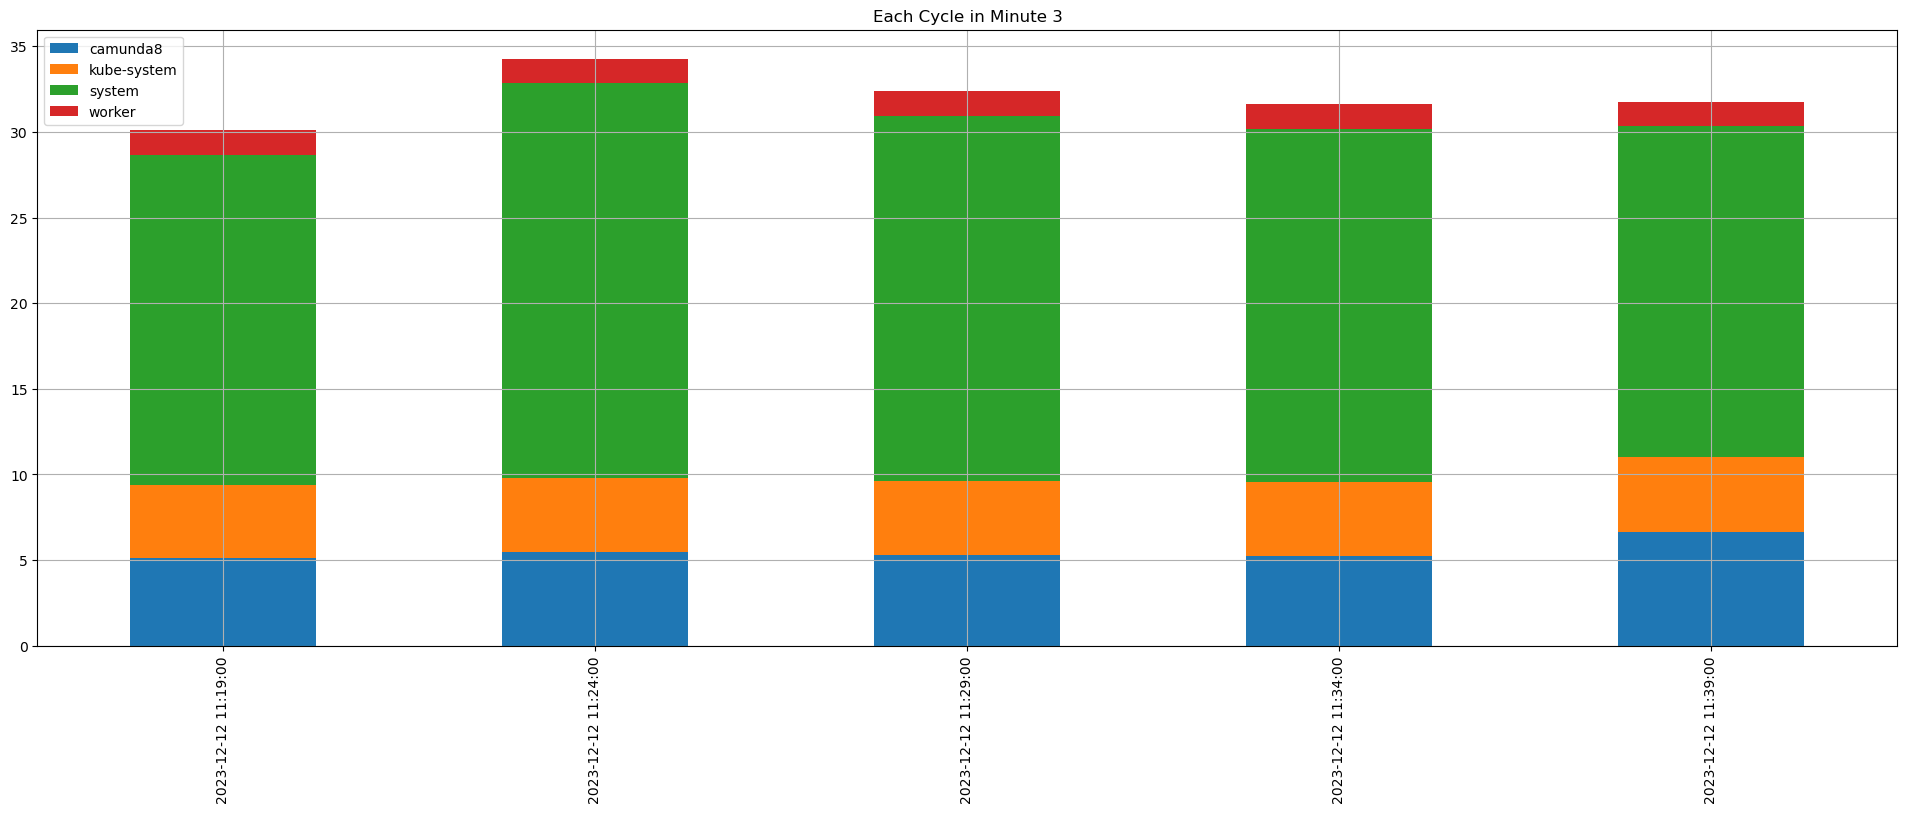

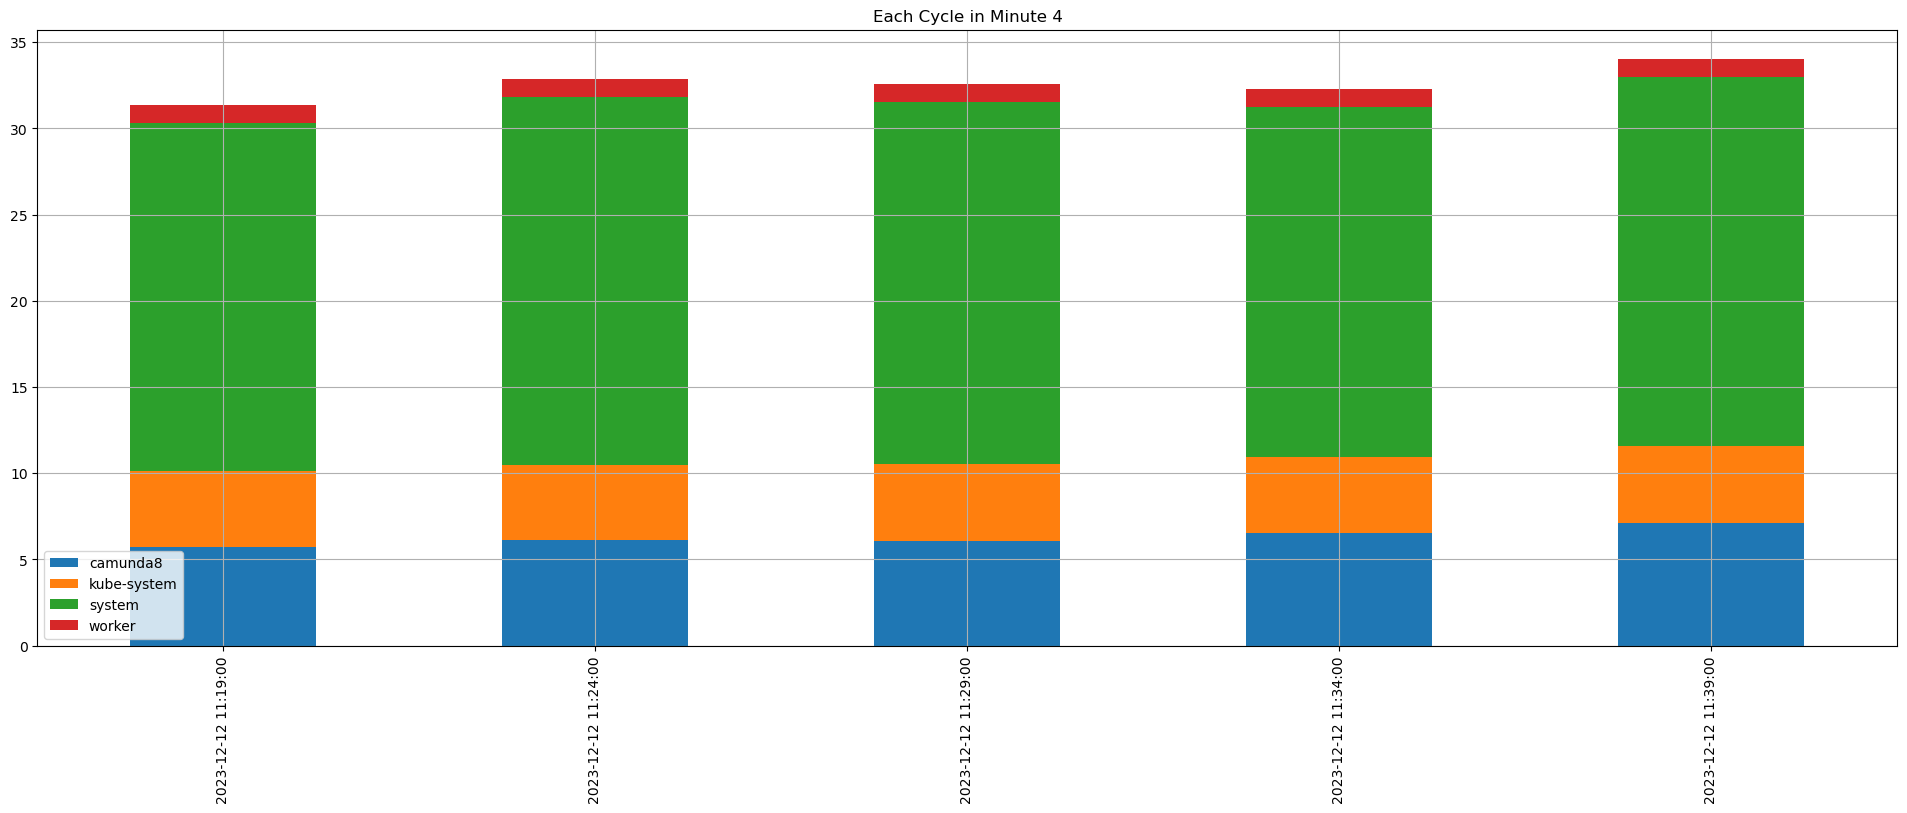

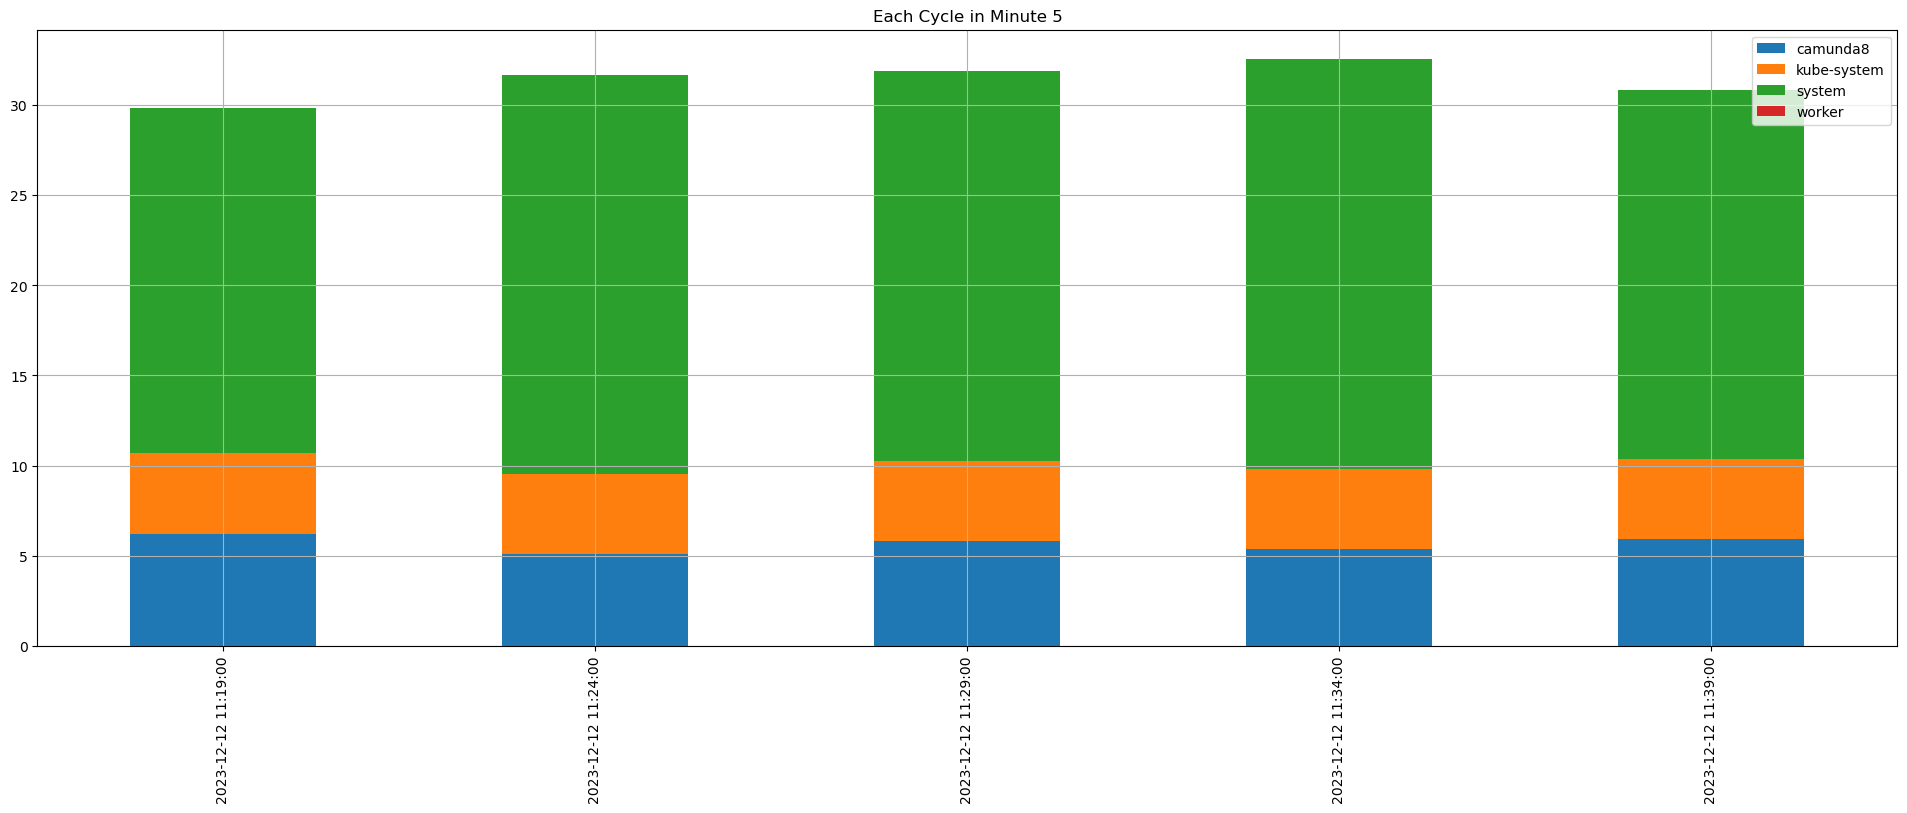

In [ ]:
# create sums by minute

def create_min_by_namespace(cycles_by_namespace, min):
    min_by_namespace = pd.DataFrame()
    index=create_relative_timestamps(0,60,10)
    for item in cycles_by_namespace:
        min_by_namespace[item.index[0]] = pd.DataFrame(item.iloc[ (min - 1) * 6 : min * 6 ,:]).sum(axis=0)
        
    min_by_namespace = min_by_namespace.transpose()
    return min_by_namespace

min1_by_namespace = create_min_by_namespace(cycles_by_namespace,1)
min2_by_namespace = create_min_by_namespace(cycles_by_namespace,2)
min3_by_namespace = create_min_by_namespace(cycles_by_namespace,3)
min4_by_namespace = create_min_by_namespace(cycles_by_namespace,4)
min5_by_namespace = create_min_by_namespace(cycles_by_namespace,5)

min1_by_namespace.plot(kind='bar', stacked=True, figsize=[24,8], title= "Each Cycle in Minute 1", grid=True)
min2_by_namespace.plot(kind='bar', stacked=True, figsize=[24,8], title= "Each Cycle in Minute 2", grid=True)
min3_by_namespace.plot(kind='bar', stacked=True, figsize=[24,8], title= "Each Cycle in Minute 3", grid=True)
min4_by_namespace.plot(kind='bar', stacked=True, figsize=[24,8], title= "Each Cycle in Minute 4", grid=True)
min5_by_namespace.plot(kind='bar', stacked=True, figsize=[24,8], title= "Each Cycle in Minute 5", grid=True)

#### Outliers:

**Min1**

- '2023-12-10 05:21:00'
- '2023-12-10 06:01:00'

**Min5**

- '2023-12-10 05:56:00'
- '2023-12-10 03:56:00'

#### Cleaning up

In [ ]:
# drop outliers from rawdata
outliers = [
    '2023-12-10 11:58:00', 
    '2023-12-10 09:58:00', 
]

start_times_clean = [time for time in start_times if time not in outliers]

In [ ]:
cycles_clean = split_data_into_cycles(data, start_times_clean,STEPS_PER_CYCLE)
cycles_by_namespace_clean = group_namespaces_per_cycle(cycles_clean)

all_camunda_series_clean = isolate_namespace_per_cycle("camunda8", cycles_by_namespace_clean)
all_system_series_clean = isolate_namespace_per_cycle("system", cycles_by_namespace_clean)
all_worker_series_clean = isolate_namespace_per_cycle("worker", cycles_by_namespace_clean)
all_kube_system_series_clean = isolate_namespace_per_cycle("kube-system", cycles_by_namespace_clean)

<Axes: title={'center': 'Each Cycle in Minute 5 - cleaned'}>

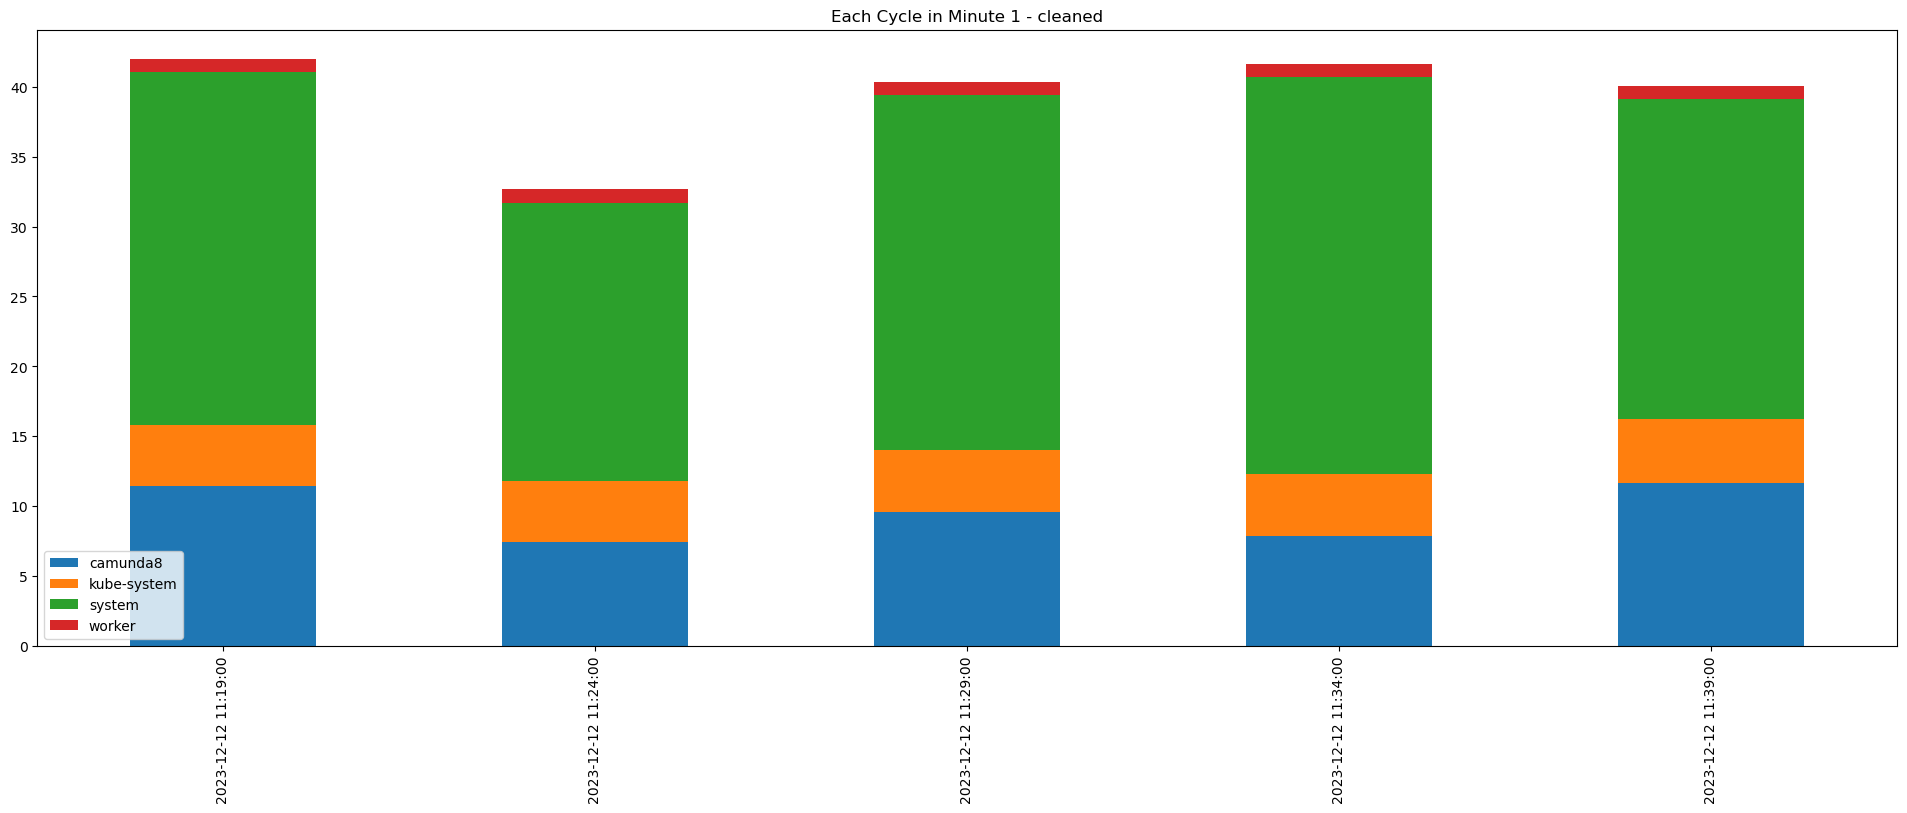

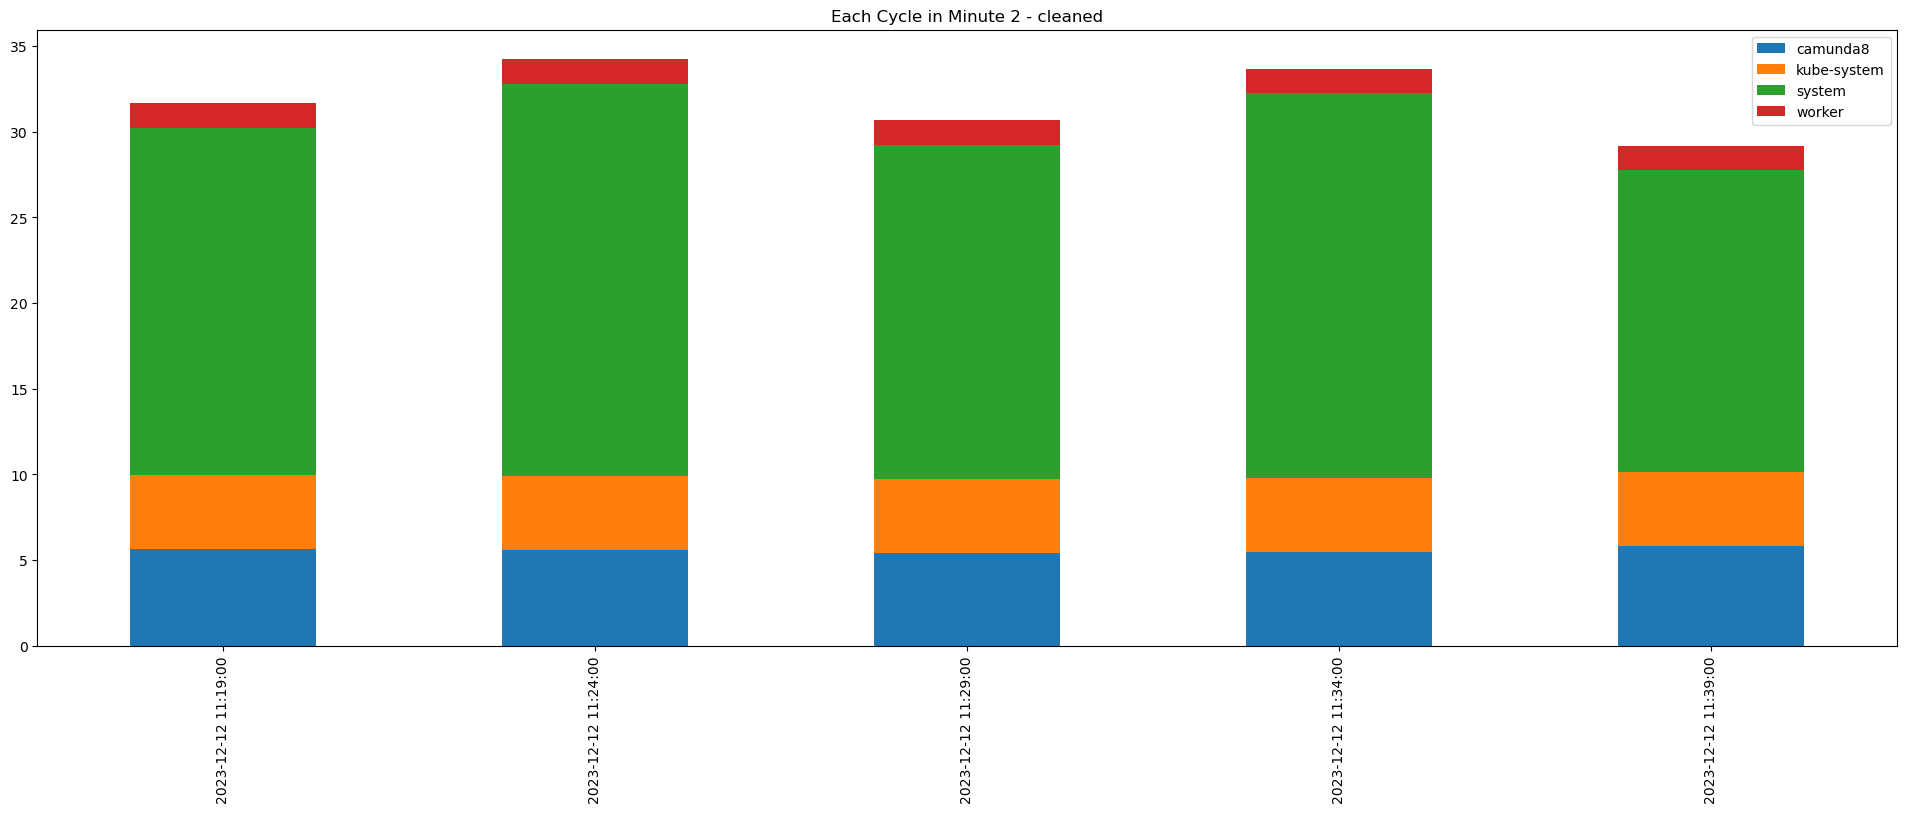

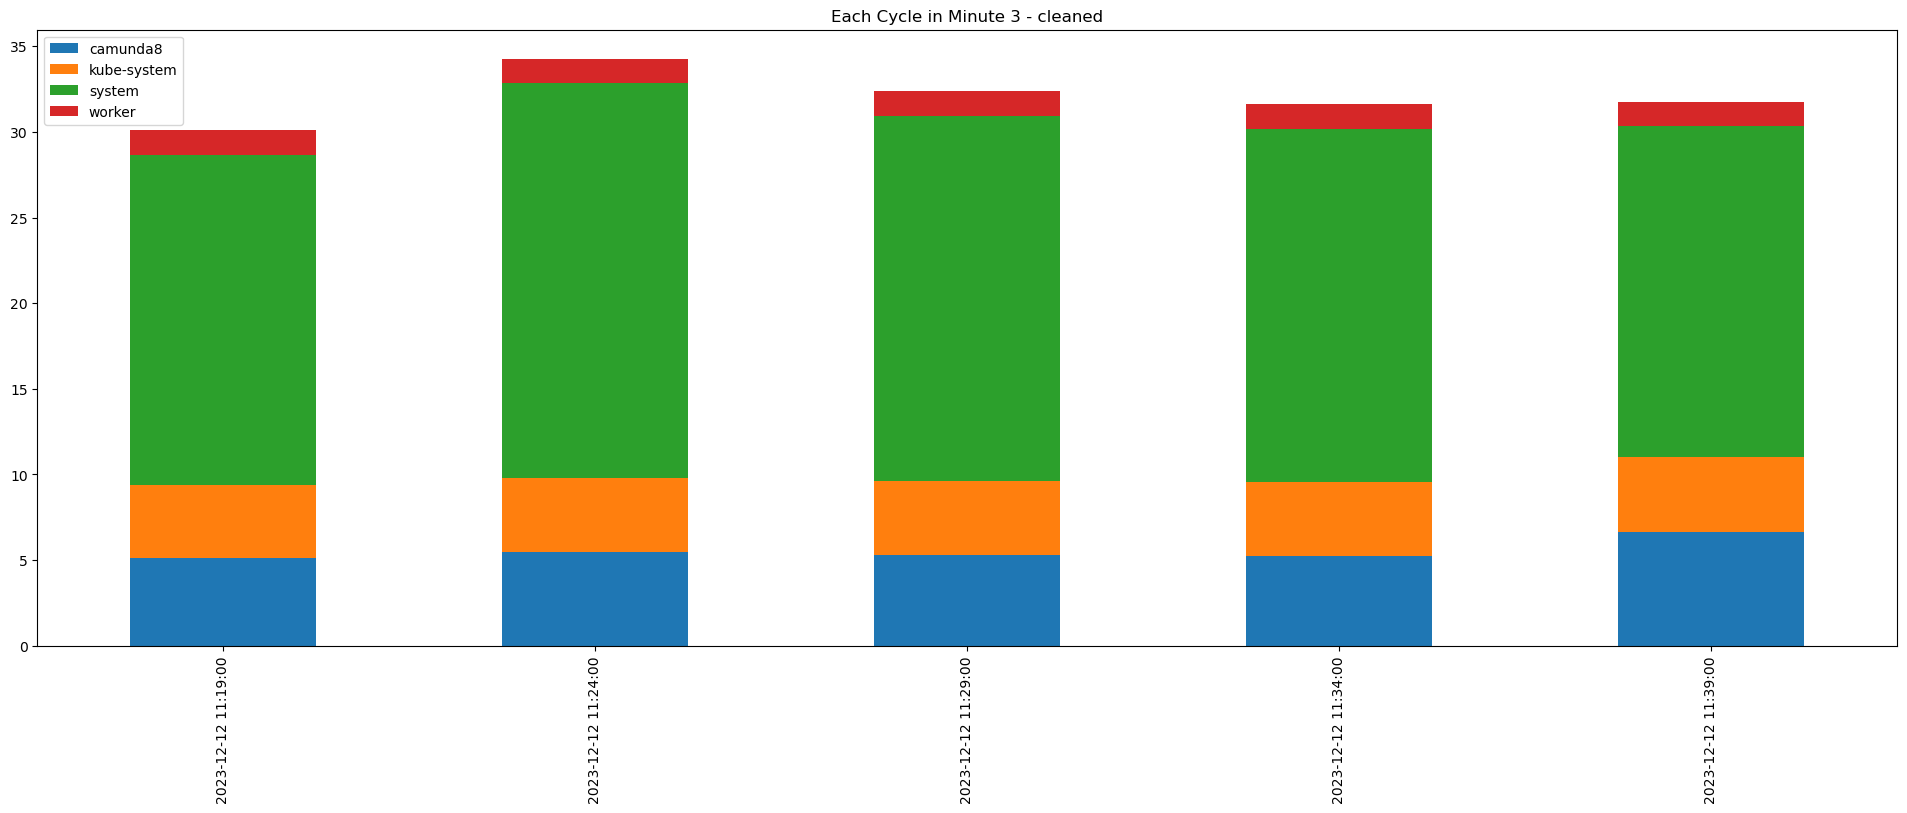

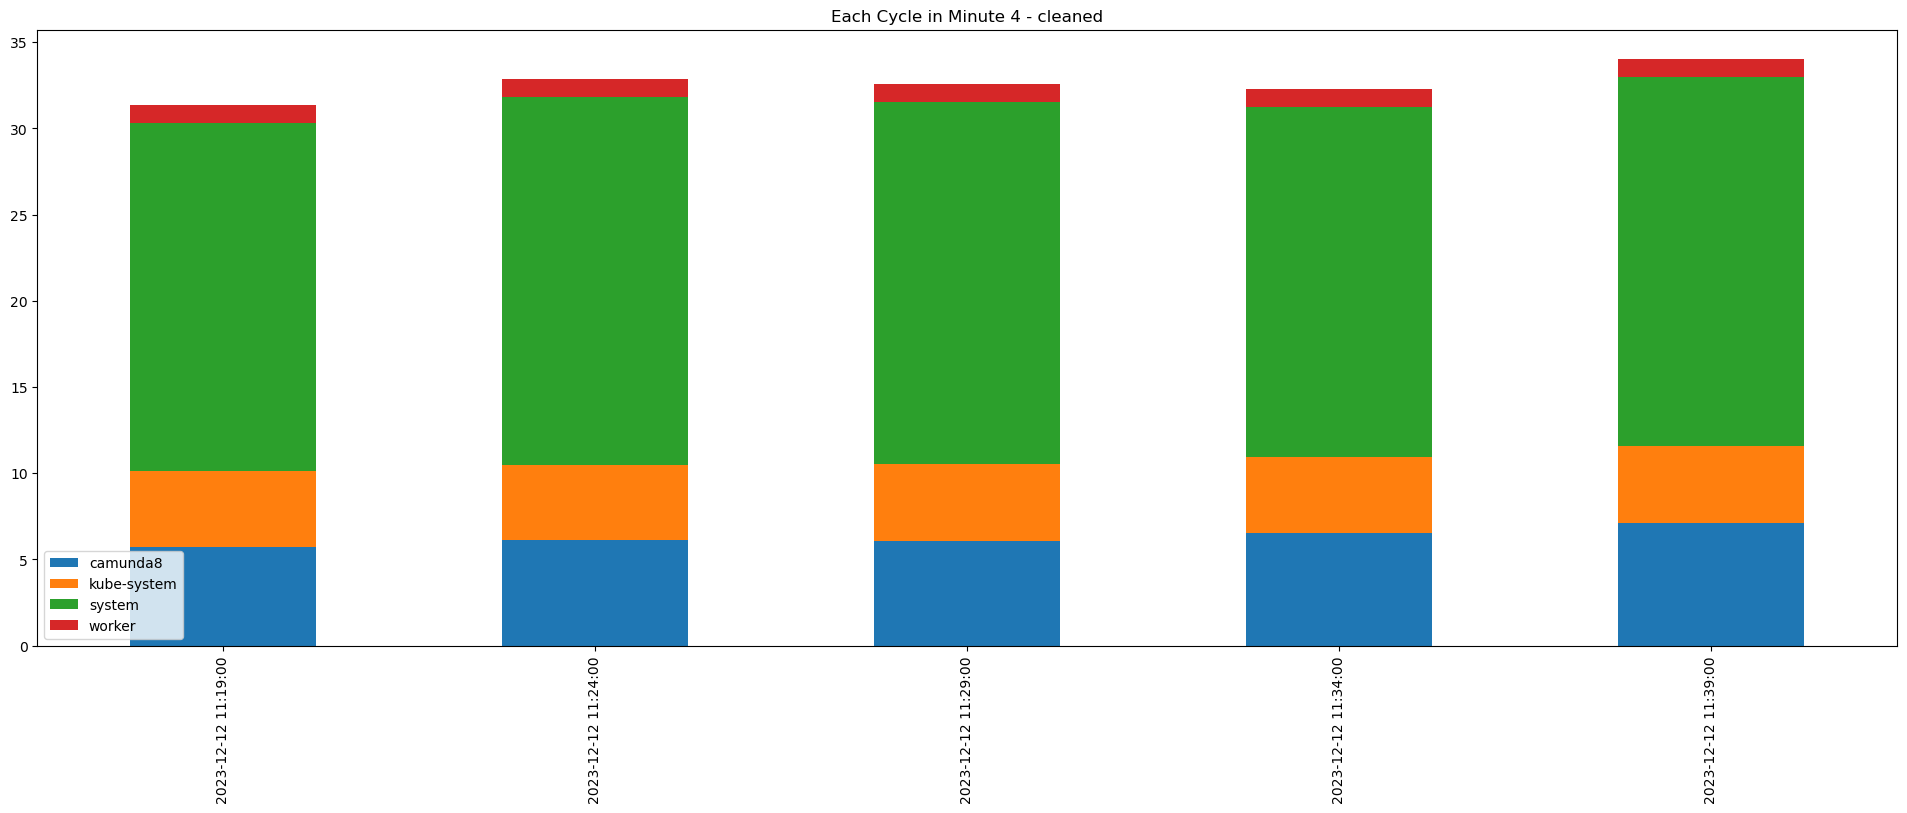

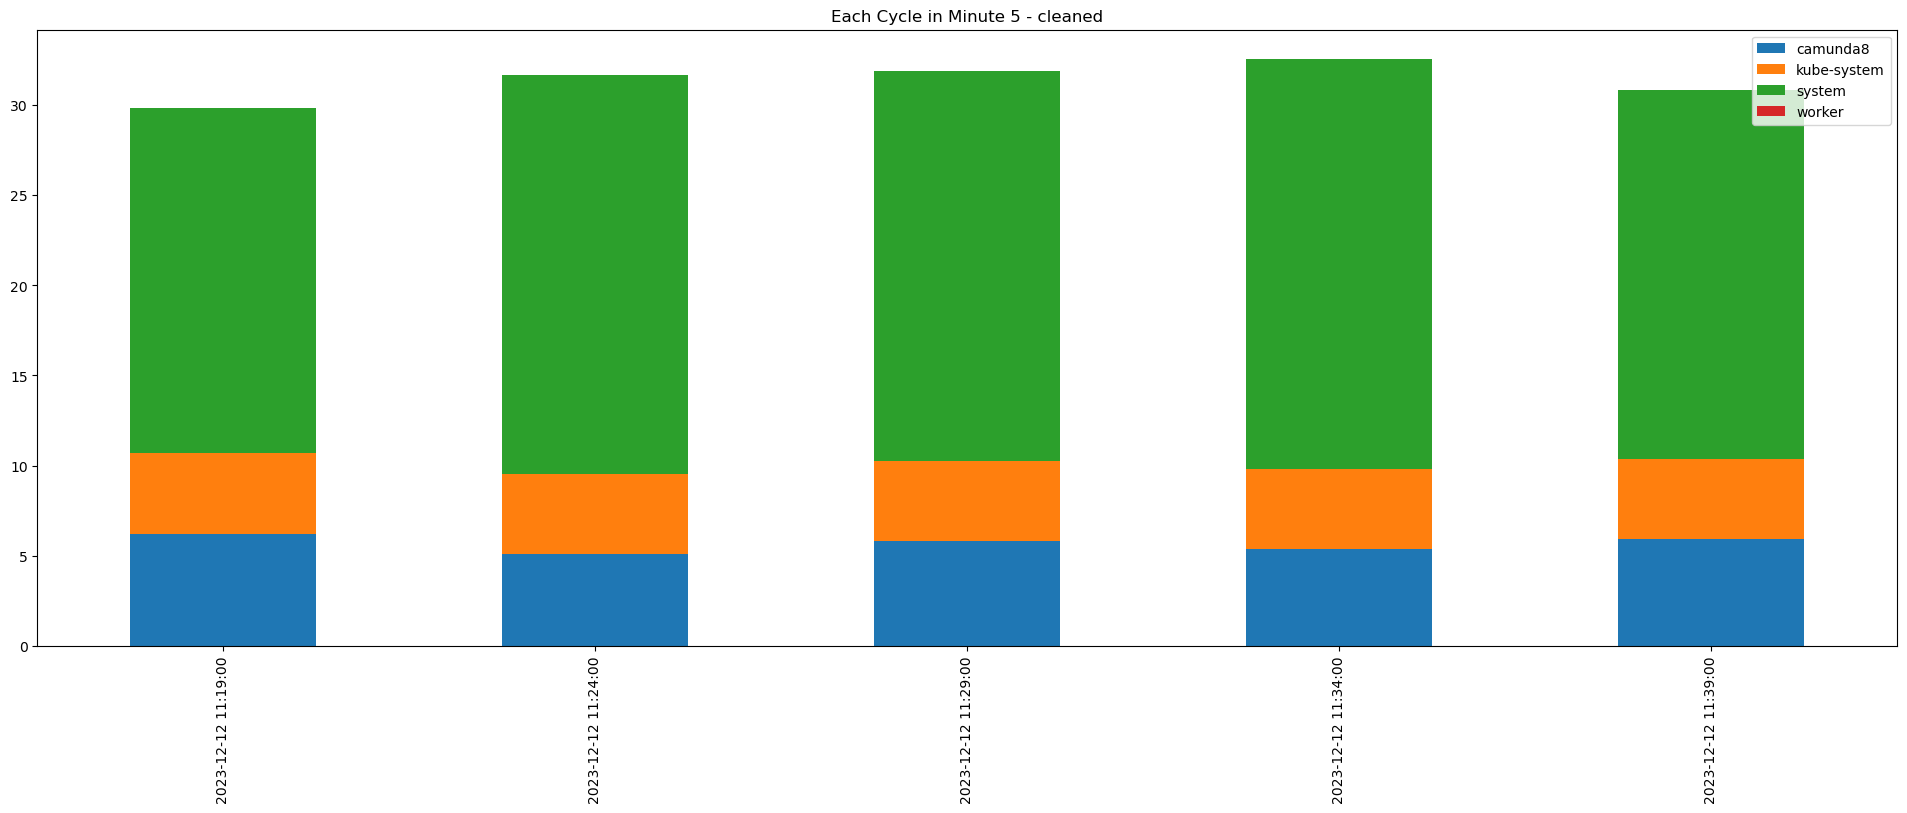

In [ ]:
min1_by_namespace = create_min_by_namespace(cycles_by_namespace_clean,1)
min2_by_namespace = create_min_by_namespace(cycles_by_namespace_clean,2)
min3_by_namespace = create_min_by_namespace(cycles_by_namespace_clean,3)
min4_by_namespace = create_min_by_namespace(cycles_by_namespace_clean,4)
min5_by_namespace = create_min_by_namespace(cycles_by_namespace_clean,5)

min1_by_namespace.plot(kind='bar', stacked=True, figsize=[24,8], title= "Each Cycle in Minute 1 - cleaned")
min2_by_namespace.plot(kind='bar', stacked=True, figsize=[24,8], title= "Each Cycle in Minute 2 - cleaned")
min3_by_namespace.plot(kind='bar', stacked=True, figsize=[24,8], title= "Each Cycle in Minute 3 - cleaned")
min4_by_namespace.plot(kind='bar', stacked=True, figsize=[24,8], title= "Each Cycle in Minute 4 - cleaned")
min5_by_namespace.plot(kind='bar', stacked=True, figsize=[24,8], title= "Each Cycle in Minute 5 - cleaned")

<Axes: title={'center': 'System'}, xlabel='Time', ylabel='Consumed Power [W] - cleaned'>

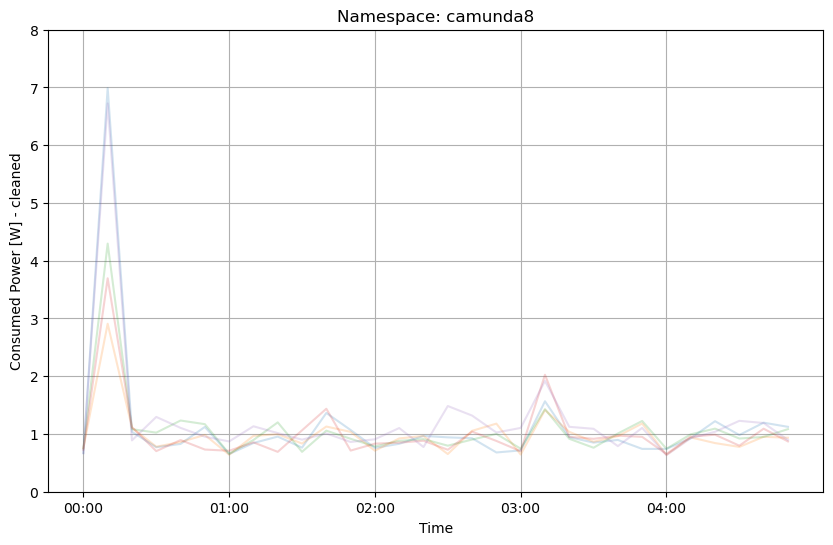

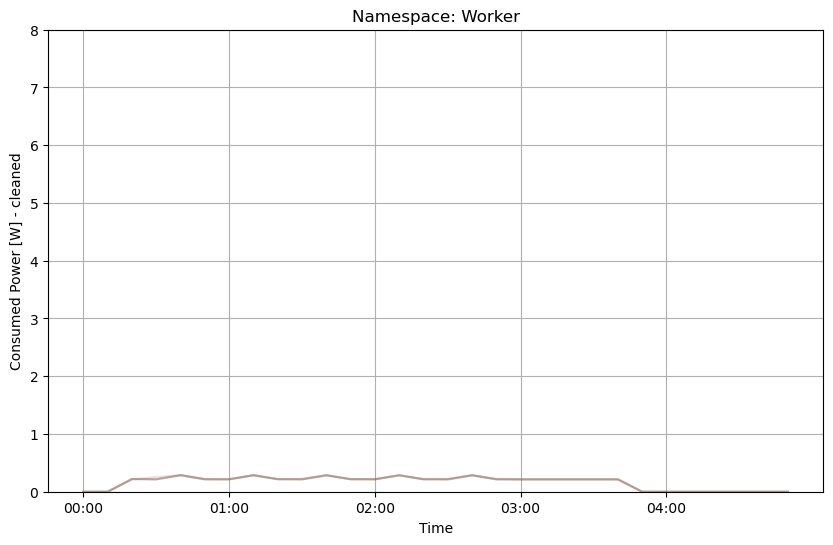

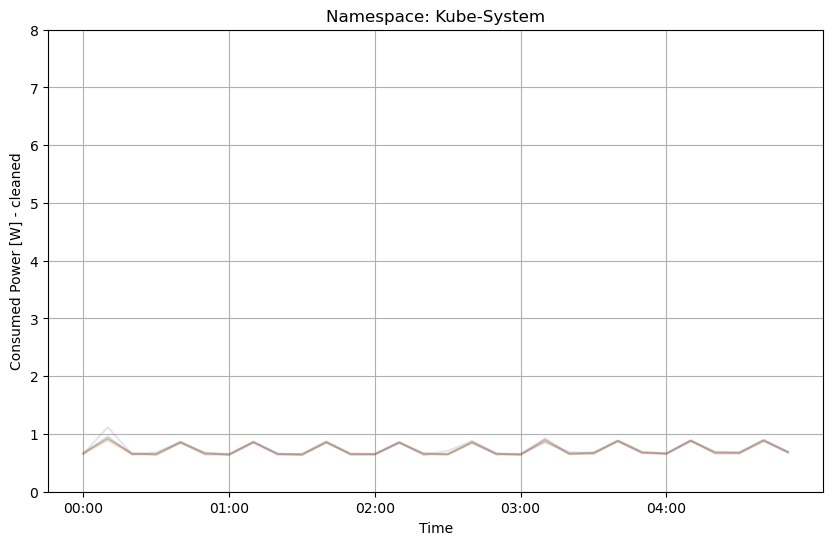

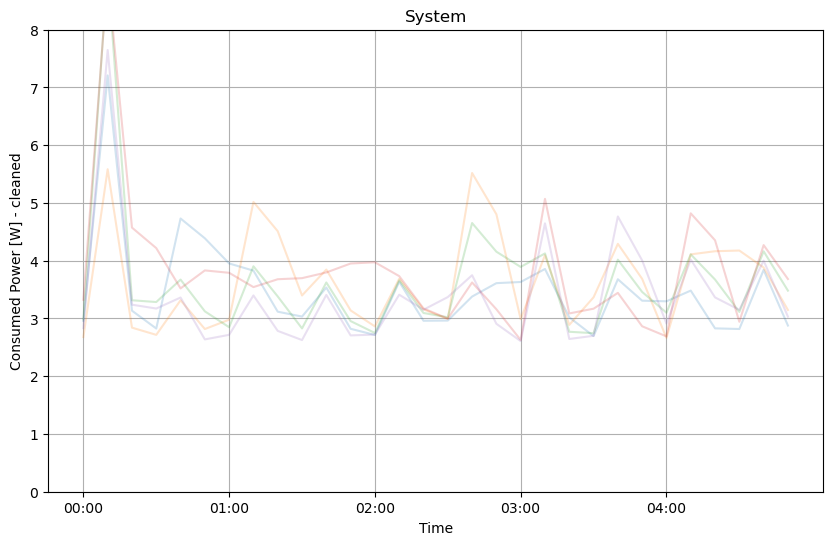

In [ ]:
all_camunda_series_clean.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: camunda8", xlabel='Time', ylabel='Consumed Power [W] - cleaned')
all_worker_series_clean.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: Worker", xlabel='Time', ylabel='Consumed Power [W] - cleaned')
all_kube_system_series_clean.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: Kube-System", xlabel='Time', ylabel='Consumed Power [W] - cleaned')
all_system_series_clean.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "System", xlabel='Time', ylabel='Consumed Power [W] - cleaned')

In [ ]:
index = [ 'Min1', 'Min2', 'Min3', 'Min4', 'Min5' ]

def create_avg_by_min_series(df, new_index):
    series_avg = df.mean(axis=1)
    temp = pd.Series(index=new_index)
    
    for i in range(0,5):
        temp[i] = series_avg[i * 6 : (i + 1) * 6].sum()

    return temp


avg_by_min = pd.DataFrame(index = index)


avg_by_min['system'] = create_avg_by_min_series(all_system_series_clean, index)
avg_by_min['kube-system'] = create_avg_by_min_series(all_kube_system_series_clean, index)
avg_by_min['camunda8'] = create_avg_by_min_series(all_camunda_series_clean,index)
avg_by_min['worker'] = create_avg_by_min_series(all_worker_series_clean, index)

avg_by_min


,system,kube-system,camunda8,worker
Min1,24.38254,4.44994,9.57408,0.94490
Min2,20.56412,4.31192,5.58512,1.43646
Min3,20.71878,4.32938,5.53802,1.43374
Min4,20.83032,4.42312,6.30980,1.07050
Min5,21.23438,4.46478,5.66490,0.00000


<Axes: title={'center': 'Average Power Consumption by Minute'}, ylabel='Avg Consumed Power [W/Min]'>

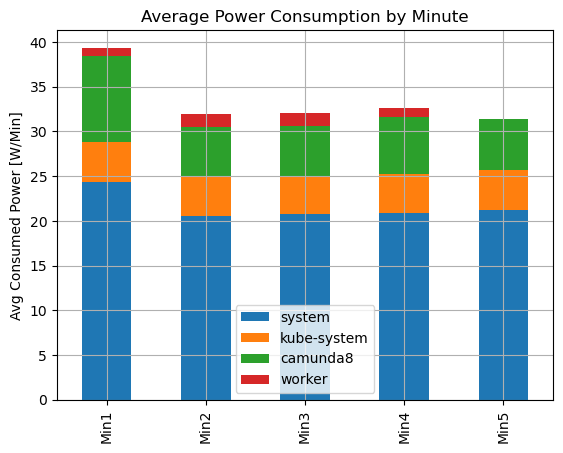

In [ ]:
# plot average consumption per minute
# ylim=[0,8] 
figsize = [10,6]
alpha=0.2
grid=True

avg_by_min.plot(
    kind="bar",
    stacked=True,
    title = 'Average Power Consumption by Minute',
    grid=True,
    ylabel='Avg Consumed Power [W/Min]'
)

In [ ]:
avg_idle = min5_by_namespace.mean(axis=0)

avg_idle


camunda8        5.66490
kube-system     4.46478
system         21.23438
worker          0.00000
dtype: float64

### Calculating Idle

**Min5** is running 1 worker, so this will serve as a baseline. Since no operations are being done in 'kube-system' and 'system', disregard namespaces for Idle. **only 'worker' and 'zeebe' remain.**

<Axes: title={'center': 'Difference Avg Min 2-3 to Min 5'}>

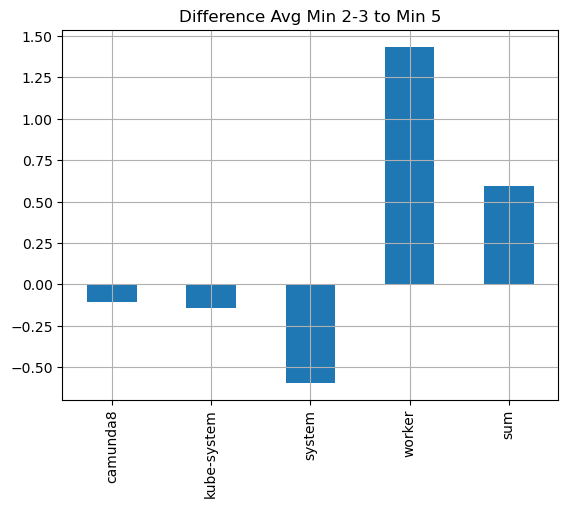

In [ ]:
min2_3 = avg_by_min['Min2':'Min3']
min2_3 = min2_3.transpose()

min2_3_avg = min2_3.mean(axis=1)

# min2_3_avg

diff_idle =  avg_by_min['Min2':'Min3'].mean(axis=0) - avg_idle
diff_idle['sum'] = diff_idle.sum(axis=0)

diff_idle.plot(kind="bar", grid=True, title="Difference Avg Min 2-3 to Min 5")

# Calculating Start-Up

In **Min1**,  a worker is started. Taking **min2_3_avg** and subtracting it from **Min1** should only leave energy needed for starting a worker

<Axes: title={'center': 'Difference Avg Min 1 (starting worker) to idle minutes'}>

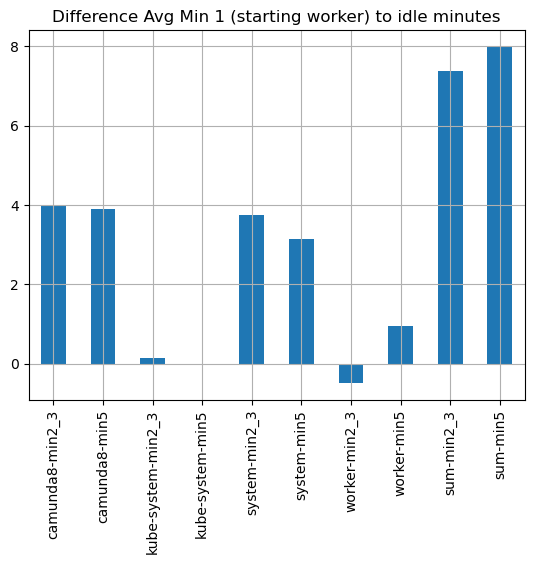

In [ ]:
diff_startup_tomin2_3 = (avg_by_min.loc['Min1',:].transpose() - min2_3_avg).add_suffix("-min2_3")
diff_startup_tomin5 = (avg_by_min.loc['Min1',:].transpose() - avg_idle).add_suffix("-min5")

diff_startup = pd.concat([diff_startup_tomin2_3,diff_startup_tomin5])
diff_startup = diff_startup.sort_index(axis=0)
diff_startup['sum-min2_3'] = diff_startup_tomin2_3.sum()
diff_startup['sum-min5'] = diff_startup_tomin5.sum()

diff_startup.plot(kind="bar", grid=True, title="Difference Avg Min 1 (starting worker) to idle minutes")

# Calculating Shutdown

In **Min4**,  the started worker is stopped. Taking **min2_3_avg** and subtracting it from **Min4** should only leave energy needed for starting a worker

<Axes: title={'center': 'Difference Avg Min 4 (stopping worker) to idle minutes'}>

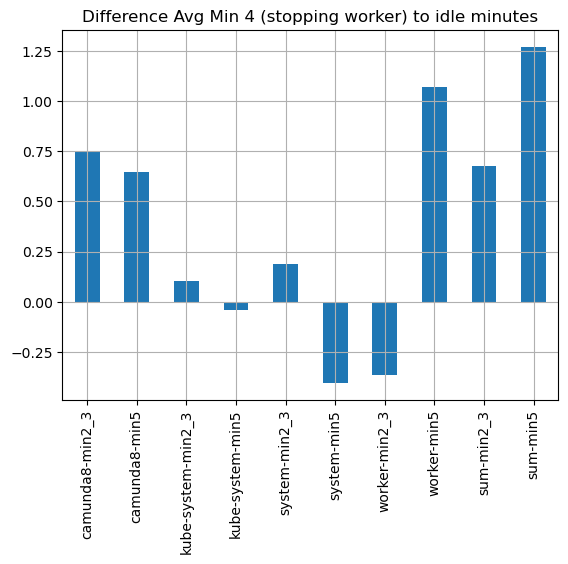

In [ ]:
diff_shutdown_tomin2_3 = (avg_by_min.loc['Min4',:].transpose() - min2_3_avg).add_suffix("-min2_3")
diff_shutdown_tomin5 = (avg_by_min.loc['Min4',:].transpose() - avg_idle).add_suffix("-min5")

diff_shutdown = pd.concat([diff_shutdown_tomin2_3,diff_shutdown_tomin5])
diff_shutdown = diff_shutdown.sort_index(axis=0)
diff_shutdown['sum-min2_3'] = diff_shutdown_tomin2_3.sum()
diff_shutdown['sum-min5'] = diff_shutdown_tomin5.sum()

diff_shutdown.plot(kind="bar", grid=True, title="Difference Avg Min 4 (stopping worker) to idle minutes")

In [ ]:
# generating key indicators
indicators = pd.Series()

indicators['idle consumption [W/Min]'] = diff_idle['sum']
indicators['startup_cost [W/Min]'] = diff_startup['sum-min2_3']
indicators['shutdown_cost [W/Min]'] = diff_shutdown['sum-min2_3']
indicators['up_and_down_cost [W/Min]'] = indicators['startup_cost [W/Min]'] + indicators['shutdown_cost [W/Min]']
indicators['max_idle_time [Min]'] = indicators['up_and_down_cost [W/Min]'] / indicators['idle consumption [W/Min]']

indicators


idle consumption [W/Min]     0.594710
startup_cost [W/Min]         7.392690
shutdown_cost [W/Min]        0.674970
up_and_down_cost [W/Min]     8.067660
max_idle_time [Min]         13.565704
dtype: float64

# Conclusion

## Idle

1) For namespaces 'system' and 'kube-system', an idling worker has negligible energy impact. 
2) For namespaces 'camunda8' (in these measurements only consisting of 'zeebe' and 'zeebe-gateway') and 'worker' the idle consumption is around **1.4W/min**

## Startup

1) Starting a worker pod has impact for all namespaces
2) For all namespaces combined, the minute the worker is started takes around **9.6W** more than the idle minutes
3) Most energy goes to 'system' (~4W) and 'camunda8' (~5W)

## Shutdown

1) Comparing the minute the worker shuts down to an idle minute, shutting down takes in total around **1.8W** more
2) shutting down mostly takes energy in the 'camunda8' (~0.5W) and 'system' (~1.1W) namespaces

## Putting it together

The sum of shutting down and starting back up is around **11,4W**, surpassing idle consumption after around **8Min**